In [ ]:
# ================================
# COCO Dataset Classification with AlexNet, ZFNet, and VGGNet
# Validation Error Chart Included
# ================================

# Import necessary libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision.datasets import CocoDetection
from pycocotools.coco import COCO

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ================================
# 1️⃣ COCO Dataset Loading
# ================================



# ================================
# 2️⃣ Helper Functions
# ================================

# Function to display images in a grid
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Function for inference and visualization
def infer_and_visualize(model, images, labels, model_name):
    """Infer and display predictions."""
    model.eval()

    with torch.no_grad():
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    print(f"\n{model_name} Predictions:")
    imshow(torchvision.utils.make_grid(images.cpu()))
    print('Predicted:', ' '.join(f'{classes[preds[j]]}' for j in range(len(preds))))
    print('Ground Truth:', ' '.join(f'{classes[labels[j]]}' for j in range(len(labels))))

# ================================
# 3️⃣ Model Loading and Modification
# ================================

# Load pre-trained models
alexnet = torchvision.models.alexnet(pretrained=True).to(device)
vgg16 = torchvision.models.vgg16(pretrained=True).to(device)

# Define a simplified ZFNet model architecture
class ZFNet(nn.Module):
    def __init__(self, num_classes=80):
        super(ZFNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=7, stride=2, padding=1),  # Larger kernel
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Load ZFNet
zfnet = ZFNet(num_classes=80).to(device)

# ================================
# 4️⃣ Modify Pre-trained Models for COCO
# ================================

# Function to modify the final FC layer to fit COCO (80 classes)
def modify_model_for_coco(model, num_classes=80):
    """Modify the output layer to match COCO classes."""
    for param in model.parameters():
        param.requires_grad = False  # Freeze the pre-trained layers

    # Replace the classifier output layer
    if isinstance(model, torchvision.models.AlexNet):
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif isinstance(model, torchvision.models.VGG):
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

    model = model.to(device)
    return model

# Modify the models for COCO
alexnet = modify_model_for_coco(alexnet)
vgg16 = modify_model_for_coco(vgg16)

# ZFNet is already designed for 80 classes, no need for modification

# ================================
# 5️⃣ Perform Inference
# ================================

# Select a batch of images and labels
images, targets = next(iter(testloader))

# Extract only the label from the COCO targets
labels = [target['category_id'] for target in targets]

# Infer and visualize
print("\n🔍 Running Inference with AlexNet...")
infer_and_visualize(alexnet, images, labels, "AlexNet (COCO)")

print("\n🔍 Running Inference with ZFNet...")
infer_and_visualize(zfnet, images, labels, "ZFNet (COCO)")

print("\n🔍 Running Inference with VGGNet...")
infer_and_visualize(vgg16, images, labels, "VGG-16 (COCO)")

# ================================
# 6️⃣ Validation Error Visualization
# ================================

# Function to calculate validation errors
def calculate_validation_error(model, dataloader):
    """Calculate validation error for the given model."""
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for images, targets in dataloader:
            images, targets = images.to(device), targets
            labels = [target['category_id'] for target in targets]
            labels = torch.tensor(labels).to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (preds == labels).sum().item()

    accuracy = 100 * correct / total
    error = 100 - accuracy
    return error

# Get validation errors for 30 images
num_batches = 30 // batch_size

alexnet_errors = []
zfnet_errors = []
vggnet_errors = []

for i, (images, targets) in enumerate(testloader):
    if i >= num_batches:
        break

    labels = [target['category_id'] for target in targets]
    labels = torch.tensor(labels).to(device)

    alexnet_errors.append(calculate_validation_error(alexnet, [(images, targets)]))
    zfnet_errors.append(calculate_validation_error(zfnet, [(images, targets)]))
    vggnet_errors.append(calculate_validation_error(vgg16, [(images, targets)]))

# Plot validation errors
plt.figure(figsize=(12, 6))
plt.plot(alexnet_errors, label='AlexNet', marker='o')
plt.plot(zfnet_errors, label='ZFNet', marker='s')
plt.plot(vggnet_errors, label='VGGNet', marker='^')

plt.title('Validation Error on 30 Test Images (COCO)')
plt.xlabel('Batch')
plt.ylabel('Validation Error (%)')
plt.legend()
plt.grid(True)
plt.show()

# ================================
# ✅ End of Full Code
# ================================


Install PyTorch and torchvision

In [1]:
!pip install torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

Import Libraries

In [10]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Load and Preprocess the COCO Dataset

In [11]:
# Data transformations: normalization and conversion to tensors
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for VGGNet and AlexNet compatibility
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image
])

# Load CIFAR-10 dataset
batch_size = 8
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

# Class labels
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Function to Display Images

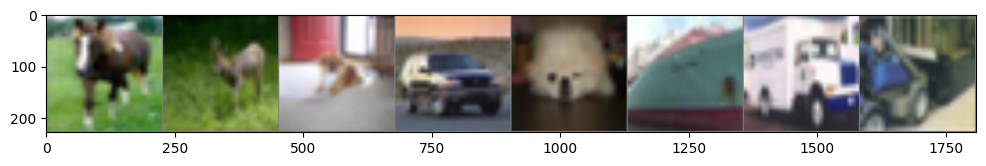

Ground Truth: horse deer dog car dog ship truck truck


In [12]:
# Function to show a batch of images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(12, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Display the images
imshow(torchvision.utils.make_grid(images))
print('Ground Truth:', ' '.join(f'{classes[labels[j]]}' for j in range(batch_size)))

Load Pre-trained Models (AlexNet, ZFNet, and VGGNet)

    AlexNet

    Introduced by Krizhevsky et al. (2012).

    Contains 5 convolutional layers, followed by 3 fully connected layers.

    Uses ReLU activation and dropout to prevent overfitting.

    Achieved remarkable performance on the ImageNet dataset.


    ZFNet

    Improved upon AlexNet with larger filters in the first convolutional layer.

    Slight modifications in filter size and stride.

    More efficient feature extraction.
    

    VGGNet

    Developed by Simonyan and Zisserman.

    Uses smaller 3x3 filters but stacks them deeper.

    Highly accurate but computationally intensive.

Load and Display Model Architectures

In [13]:
# Load pre-trained models
alexnet = torchvision.models.alexnet(pretrained=True).to(device)
vgg16 = torchvision.models.vgg16(pretrained=True).to(device)

# ZFNet is not directly available in torchvision, but we use a custom version
class ZFNet(nn.Module):
    """Simplified ZFNet architecture"""
    def __init__(self):
        super(ZFNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, kernel_size=7, stride=2, padding=1)
        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, stride=2, padding=1)
        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = torch.relu(self.conv5(x))
        x = nn.functional.adaptive_avg_pool2d(x, (6, 6))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

zfnet = ZFNet().to(device)

# Display model architectures
print("\n🔹 AlexNet Architecture:")
summary(alexnet, (3, 224, 224))

print("\n🔹 ZFNet Architecture:")
summary(zfnet, (3, 224, 224))

print("\n🔹 VGG-16 Architecture:")
summary(vgg16, (3, 224, 224))


🔹 AlexNet Architecture:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPoo

Model Inference and Classification


🔍 Running Inference with AlexNet...

AlexNet (CIFAR-10) Predictions:


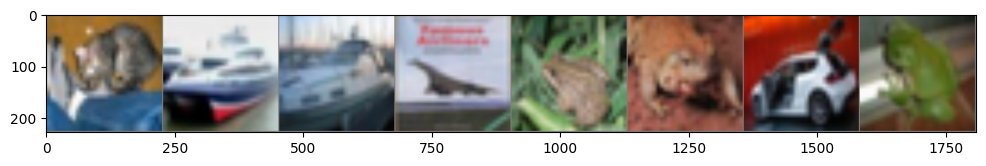

Predicted: plane frog frog truck dog dog car car
Ground Truth: cat ship ship plane frog frog car frog

🔍 Running Inference with ZFNet...

ZFNet (CIFAR-10) Predictions:


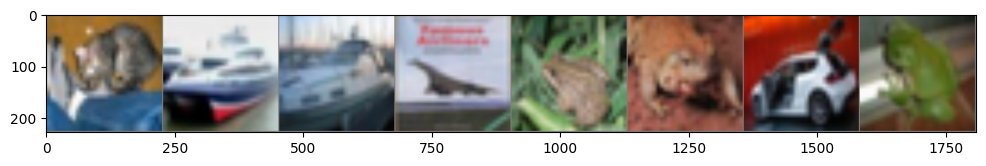

Predicted: dog dog dog dog dog dog dog dog
Ground Truth: cat ship ship plane frog frog car frog

🔍 Running Inference with VGGNet...

VGG-16 (CIFAR-10) Predictions:


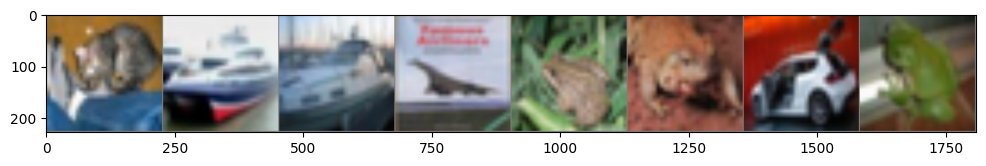

Predicted: bird bird bird bird bird bird bird bird
Ground Truth: cat ship ship plane frog frog car frog


In [14]:
# Function to modify the final FC layer to fit CIFAR-10 (10 classes)
def modify_model_for_cifar10(model, num_classes=10):
    """Modify the output layer to match CIFAR-10 classes."""
    for param in model.parameters():
        param.requires_grad = False  # Freeze the pre-trained layers

    # Replace the classifier output layer
    if isinstance(model, torchvision.models.AlexNet):
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif isinstance(model, torchvision.models.VGG):
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

    model = model.to(device)
    return model

# Modify the models for CIFAR-10
alexnet = modify_model_for_cifar10(alexnet)
vgg16 = modify_model_for_cifar10(vgg16)

# ZFNet is already designed for 10 classes, no need for modification


# 5️⃣ Perform Inference


# Select a batch of images and labels
images, labels = next(iter(testloader))

# Infer and visualize
print("\n🔍 Running Inference with AlexNet...")
infer_and_visualize(alexnet, images, labels, "AlexNet (CIFAR-10)")

print("\n🔍 Running Inference with ZFNet...")
infer_and_visualize(zfnet, images, labels, "ZFNet (CIFAR-10)")

print("\n🔍 Running Inference with VGGNet...")
infer_and_visualize(vgg16, images, labels, "VGG-16 (CIFAR-10)")


Validation Error Visualization

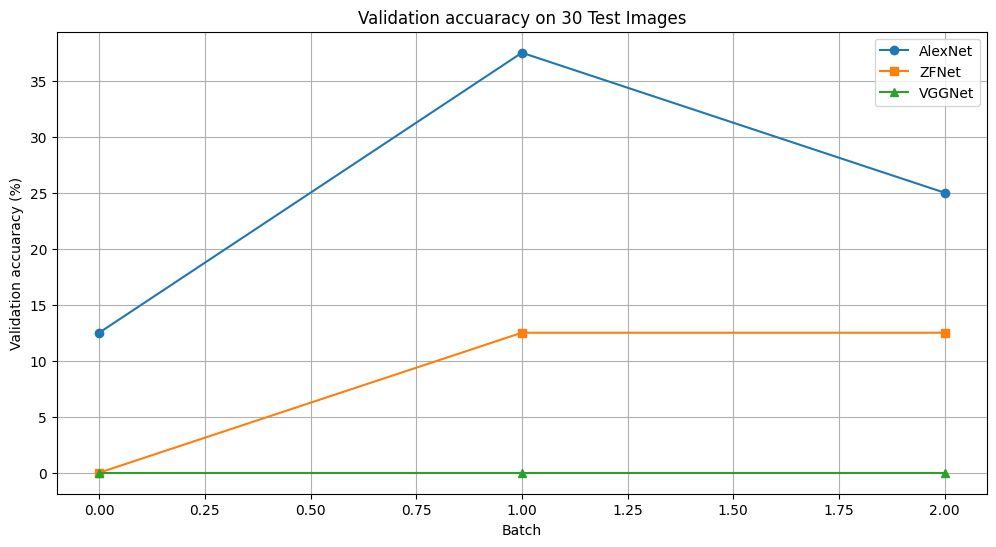

In [16]:
# Function to calculate validation errors
def calculate_validation_accuracy(model, dataloader):
    """Calculate validation error for the given model."""
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (preds == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Get validation errors for 30 images
num_batches = 30 // batch_size

alexnet_accuaracy = []
zfnet_accuaracy = []
vggnet_accuaracy = []

for i, (images, labels) in enumerate(testloader):
    if i >= num_batches:
        break

    alexnet_accuaracy.append(calculate_validation_accuracy(alexnet, [(images, labels)]))
    zfnet_accuaracy.append(calculate_validation_accuracy(zfnet, [(images, labels)]))
    vggnet_accuaracy.append(calculate_validation_accuracy(vgg16, [(images, labels)]))

# Plot validation errors
plt.figure(figsize=(12, 6))
plt.plot(alexnet_accuaracy, label='AlexNet', marker='o')
plt.plot(zfnet_accuaracy, label='ZFNet', marker='s')
plt.plot(vggnet_accuaracy, label='VGGNet', marker='^')

plt.title('Validation accuaracy on 30 Test Images')
plt.xlabel('Batch')
plt.ylabel('Validation accuaracy (%)')
plt.legend()
plt.grid(True)
plt.show()